Activity 1
Analog IC Characterization: The Wideband RC Voltage-Divider

I. INTRODUCTION

The frequency-independent signal attenuator is a fundamental building block in high-bandwidth analog measurement systems, where accurate signal scaling must be maintained over a wide range of frequencies. Simple resistive voltage dividers, while effective at low frequencies, often exhibit frequency-dependent behavior when parasitic capacitances and source or load impedances are introduced. These effects become especially pronounced in wideband applications, leading to signal distortion, amplitude errors, and phase shift.

To address these limitations, RC compensation techniques are employed. By intentionally adding capacitive elements in parallel with resistive components, the frequency response of the divider can be shaped to achieve flat attenuation across a broad spectrum. This principle is widely used in practical instrumentation such as oscilloscope probes, data acquisition front-ends, and analog integrated circuits, where maintaining signal integrity is critical.

This laboratory activity examines the wideband RC voltage divider as a representative analog IC building block. Students will explore the theoretical basis of RC compensation, including pole-zero cancellation and time-constant matching, and observe how these concepts translate into real circuit behavior. Emphasis is placed on understanding how component values influence bandwidth, transient response, and overall signal fidelity.

In addition to theory, the laboratory integrates circuit simulation using NGSPICE within a Visual Studio Code (VS Code) workflow. This environment mirrors modern engineering practice by combining schematic-level analysis with script-based simulation and waveform inspection. Through simulation, students will characterize both uncompensated and compensated dividers in the time and frequency domains, reinforcing the connection between mathematical models and observable circuit performance.

II. MATERIALS AND EQUIPMENT

Computing Workstation (PC or Laptop)

Integrated Development Environment (IDE): Visual Studio Code

NGSPICE Simulator: (Version 42+)

Python 3.x (pandas, matplotlib, numpy, schemdraw)

III. PROCEDURES

PHASE 1: INSTALLATION & SYSTEM CONFIGURATION

Step 1: Install NGSPICE (The Simulator)

    Download ngspice-42_64.zip from the NGSPICE SourceForge page.

    Extract the file and copy the Spice64 folder.

    Paste it directly into the C: drive:

            C:\Spice64
    
    Verify that ngspice.exe exists in:

            C:\Spice64\bin

Step 2: Add NGSPICE to Windows PATH

    Copy Path:

        C:\Spice64\bin

    Open Edit the system environment variables.

    Under System variables → Path → Edit → New, paste the path.

    Click OK to save.

Step 3: Verify in VS Code

    Restart VS Code.

    Open the terminal (Ctrl + `).

    Run:

        ngspice -v
    
    The NGSPICE version output confirms successful installation.

PHASE 2: PYTHON ENVIRONMENT SETUP
Install Required Python Libraries

Purpose:
These libraries will be used for circuit visualization (schemdraw), data handling (pandas), numerical analysis (numpy), and plotting simulation results (matplotlib).

In [1]:
pip install schemdraw pandas matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


Verify NGSPICE Availability

Purpose:
Confirms that NGSPICE is correctly installed and accessible from the Jupyter Notebook environment before running simulations.

In [6]:
import schemdraw
import schemdraw.elements as elm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import os

# Robust verification: This checks if NGSPICE is accessible
try:
    result = subprocess.run(["ngspice", "-v"], capture_output=True, text=True)
    if result.stdout:
        # Print the first available line of the version info
        print(f"NGSPICE Found: {result.stdout.splitlines()[0]}")
    else:
        print("NGSPICE executed but returned no version text.")
except FileNotFoundError:
    print("ERROR: NGSPICE not found. Please check your Windows PATH and restart VS Code.")

NGSPICE executed but returned no version text.


PHASE 3: CIRCUIT SCHEMATIC VISUALIZATION
Draw RC Divider Circuit

Purpose:
This cell visualizes the wideband RC voltage divider, showing:
    R1 with compensation capacitor C1
    Load resistor R2 and load capacitor C2
    Input Vin and output Vout nodes

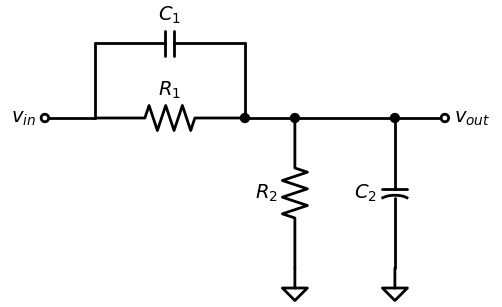

In [7]:
with schemdraw.Drawing() as d:
    d += (vin := elm.Dot(open=True).label('$v_{in}$', loc='left'))
    d += elm.Line().right().length(1)
    d.push()
    d += elm.Resistor().label('$R_1$')
    d.pop()
    d += elm.Line().up().length(1.5)
    d += elm.Capacitor().right().label('$C_1$')
    d += elm.Line().down().length(1.5)
    d += elm.Dot()
    d += elm.Line().right().length(1)
    d.push()
    d += elm.Resistor().down().label('$R_2$')
    d += elm.GroundSignal()
    d.pop()
    d += elm.Dot()
    d += elm.Line().right().length(2)
    d.push()
    d += elm.Capacitor2().down().label('$C_2$')
    d += elm.GroundSignal()
    d.pop()
    d += elm.Dot()
    d += elm.Line().right().length(1)
    d += elm.Dot(open=True).label('$v_{out}$', loc='right')

PHASE 4: NGSPICE NETLIST GENERATION & SIMULATION
Generate Netlist, Run Simulation, and Verify Output

Purpose:
    Generates a complete NGSPICE netlist using Python-defined component values.
    Runs AC and transient analyses in batch mode.
    Verifies that data files (output_ac.dat, output_tran.dat) are created for further plotting and analysis.

In [14]:
spice_netlist = """* Wideband RC Voltage Divider
.options savecurrents

* Main Circuit
R1 in out 900k
R2 out 0 100k
C1 in out 1.1111p
C2 out 0 10p

* Variations
R1a in outa 900k
R2a outa 0 100k
C1a in outa 1.6p
C2a outa 0 10p

R1b in outb 900k
R2b outb 0 100k
C1b in outb 0.7p
C2b outb 0 10p

V1 in 0 pulse(-0.1 0.1 0 0.1u 0.1u 5u 10u) dc 1 ac 1

.control
  ac dec 10 1 1G
  wrdata output_ac.dat v(out) v(outa) v(outb)
  
  tran 0.01u 30u
  wrdata output_tran.dat v(out) v(outa) v(outb)
  quit
.endc
.end
"""

with open("netlist.spice", "w") as f:
    f.write(spice_netlist)
print("netlist.spice created.")

netlist.spice created.


RUN SIMULATION WITH FILE CLEANUP
Ensure Fresh Simulation and Verify Output

Purpose:

    Ensures old simulation files are removed before running a new simulation.
    Runs NGSPICE in batch mode and verifies that AC and transient data files are generated.
    Provides immediate feedback if something goes wrong.

In [15]:
import subprocess
import os

# Remove old files to be sure we are seeing new results
for f in ["output_ac.dat", "output_tran.dat"]:
    if os.path.exists(f):
        os.remove(f)

try:
    # Running in batch mode
    subprocess.run(["ngspice", "-b", "netlist.spice"], check=True)
    
    if os.path.exists("output_tran.dat"):
        print("Success! Simulation finished and data files are ready.")
    else:
        print("Simulation finished but no data files were found.")
except subprocess.CalledProcessError as e:
    print(f"Simulation failed with error code {e.returncode}")

Success! Simulation finished and data files are ready.


PHASE 5: PLOT TRANSIENT RESPONSE
    Read and Plot Transient Data

Data detected: 6 columns


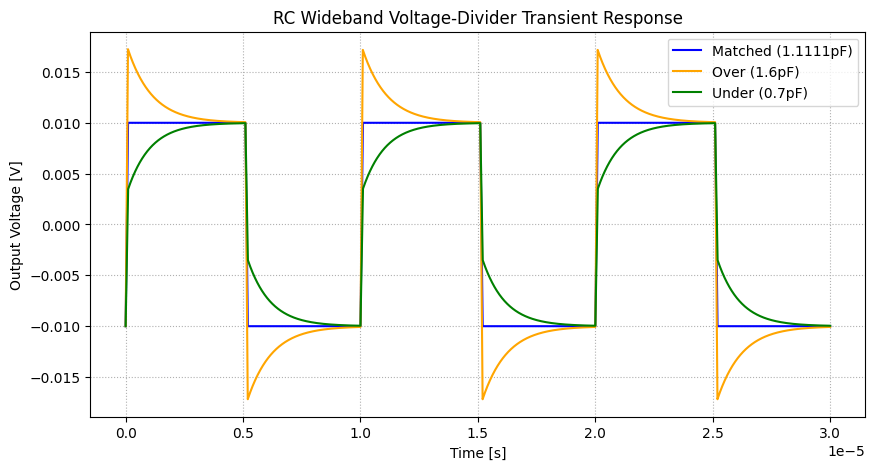

In [16]:
# Read the file without specifying columns first
df_tran = pd.read_csv("output_tran.dat", sep='\\s+', header=None)

# Let's check the shape to be safe
print(f"Data detected: {df_tran.shape[1]} columns")

# NGSPICE often exports: Time, Vout, Time, VoutA, Time, VoutB
# We only need the first Time and the Voltages
if df_tran.shape[1] == 6:
    df_tran.columns = ["time", "vout", "time2", "vouta", "time3", "voutb"]
elif df_tran.shape[1] == 4:
    df_tran.columns = ["time", "vout", "vouta", "voutb"]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df_tran['time'], df_tran['vout'], label="Matched (1.1111pF)", color='blue')
plt.plot(df_tran['time'], df_tran['vouta'], label="Over (1.6pF)", color='orange')
plt.plot(df_tran['time'], df_tran['voutb'], label="Under (0.7pF)", color='green')

plt.title("RC Wideband Voltage-Divider Transient Response")
plt.xlabel("Time [s]")
plt.ylabel("Output Voltage [V]")
plt.legend(loc='upper right')
plt.grid(True, linestyle='dotted')
plt.show()

PHASE 6: READ FREQUENCY RESPONSE DATA
Read AC Simulation Output

Purpose:
    Loads NGSPICE AC simulation results into a pandas DataFrame.
    Handles multiple output nodes and varying file formats.
    Prepares the data for plotting frequency-domain response in the next cell.

In [ ]:
# @title Read in SPICE frequency response data
df_ac = pd.read_csv("output_ac.dat", sep='\\s+', header=None)

# Handle the 9-column format (Frequency repeated for each node)
if df_ac.shape[1] == 9:
    df_ac.columns = [
        "freq", "vout_re", "vout_im", 
        "freq2", "vouta_re", "vouta_im", 
        "freq3", "voutb_re", "voutb_im"
    ]
elif df_ac.shape[1] == 7:
    df_ac.columns = ["freq", "vout_re", "vout_im", "vouta_re", "vouta_im", "voutb_re", "voutb_im"]

df_ac.head()

,freq,vout_re,vout_im,freq2,vouta_re,vouta_im,freq3,voutb_re,voutb_im
0,1.000000,0.1,-5.654867e-12,1.000000,0.1,2.488141e-07,1.000000,0.1,-2.092301e-07
1,1.258925,0.1,-7.119055e-12,1.258925,0.1,3.132384e-07,1.258925,0.1,-2.634051e-07
2,1.584893,0.1,-8.962360e-12,1.584893,0.1,3.943438e-07,1.584893,0.1,-3.316073e-07
3,1.995262,0.1,-1.128294e-11,1.995262,0.1,4.964495e-07,1.995262,0.1,-4.174689e-07
4,2.511886,0.1,-1.420438e-11,2.511886,0.1,6.249929e-07,2.511886,0.1,-5.255622e-07


PHASE 7: CALCULATE AC MAGNITUDE AND PHASE
Compute Magnitude and Phase from NGSPICE AC Data

Purpose:
    Converts NGSPICE output (real + imaginary) into magnitude and phase for each output node.
    Prepares data for frequency-domain plotting to analyze bandwidth and compensation performance.

In [21]:
# @title Calculate the magnitude and phase of the output voltage
# Note: NGSPICE writes the real and imaginary components of the voltage

# Collect all real components in a list
v_real = [ df_ac['vout_re'], df_ac['vouta_re'], df_ac['voutb_re'] ]

# Collect all imaginary components in a list
v_imag = [ df_ac['vout_im'], df_ac['vouta_im'], df_ac['voutb_im'] ]

# Iterate over the lists to get the magnitude and phase of the voltages
v_mag = [ np.sqrt(vr**2 + vi**2) for vr,vi in zip(v_real, v_imag) ]
v_phase = [ np.arctan2(vi, vr) * 180 / np.pi for vr,vi in zip(v_real, v_imag) ]

PHASE 8: PLOT AC MAGNITUDE RESPONSE
Frequency Response (Magnitude in dB)

Purpose:
    Converts voltage magnitudes to dB and plots them on a logarithmic frequency scale.
    Compares matched, over-, and under-compensation to illustrate the effect of C1 on bandwidth.
    Helps students visualize how RC compensation flattens the frequency response.

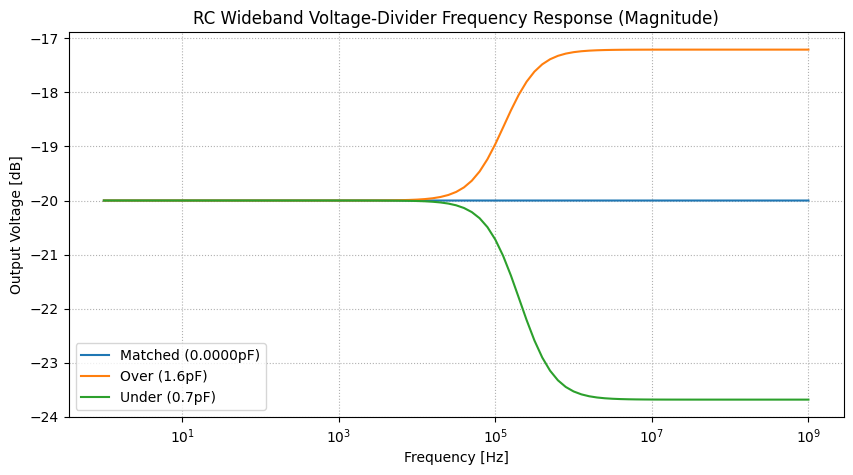

In [ ]:
# @title Plot the magnitude frequency response of the wideband RC voltage-divider

# Define labels locally to reflect the Seed-based values
# C1_matched was calculated in Cell 1
v_label = [f"Matched ({C1_matched_s:.4f}pF)", "Over (1.6pF)", "Under (0.7pF)"]

plt.figure(figsize=(10, 5))
plt.title("RC Wideband Voltage-Divider Frequency Response (Magnitude)")

# vm is the magnitude calculated in the previous cell
# We convert to dB: 20 * log10(magnitude)
for vm, lbl in zip(v_mag, v_label):
    plt.semilogx(df_ac.freq, 20 * np.log10(vm), label=lbl, linestyle='-')

plt.xlabel("Frequency [Hz]")
plt.ylabel("Output Voltage [dB]")
plt.legend(loc='lower left')
plt.grid(True, which="both", linestyle='dotted')
plt.show()

PHASE 9: PLOT AC PHASE RESPONSE
Frequency Response (Phase in Degrees)

Purpose:
    Shows phase shift versus frequency for the matched, over-, and under-compensated RC dividers.
    Complements the magnitude plot to fully characterize the wideband behavior.
    Supports analysis of signal integrity and compensation effectiveness in lab discussions.

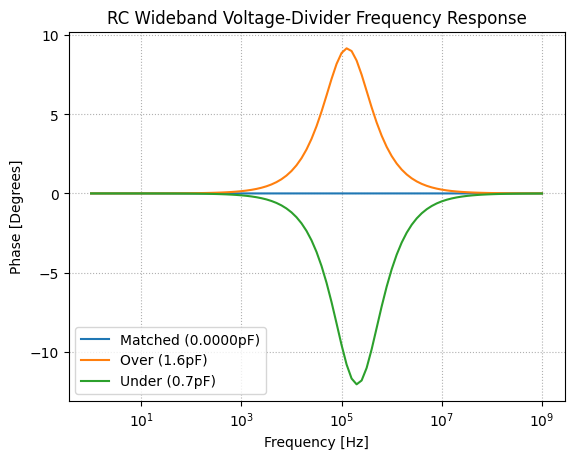

In [ ]:
# @title Plot the phase frequency response of the wideband RC voltage-divider

plt.title("RC Wideband Voltage-Divider Frequency Response")

for vp,lbl in zip(v_phase,v_label):
  plt.semilogx(df_ac.freq, vp, label=lbl, linestyle='-')

plt.xlabel("Frequency [Hz]")
plt.ylabel(r"Phase [Degrees]")
plt.legend(loc='lower left')
plt.grid(linestyle='dotted')
plt.show()

IV. DATA AND OBSERVATION

Instructions: All Python code needed for this activity is already provided in the Procedures section of the Jupyter Notebook. Do not add or write new code. Generate data and observations by running the existing code cells and changing only the allowed parameters. Record all results and observations directly in the notebook.

Instruction:

    Only modify student_number.
    Do not change any other line of code in the following cells.

In [1]:
# Student Number Input
student_number = "20220067"  # <-- Replace with your own student number

In [3]:
# Standard Series Pools
# This defines all standard resistor and capacitor values used in the simulation.

import numpy as np

# E12 Series
E12 = np.array([1.0, 1.2, 1.5, 1.8, 2.2, 2.7, 3.3, 3.9, 4.7, 5.6, 6.8, 8.2])

# Component decades (standard range)
R_decades = np.array([1e3, 10e3, 100e3, 1e6])       # 1 kΩ to 1 MΩ
C_decades = np.array([1e-12, 10e-12, 100e-12])      # 1 pF to 100 pF

# Generate full list of standard values
R_list = np.sort(np.concatenate([E12 * d for d in R_decades]))
C_list = np.sort(np.concatenate([E12 * d for d in C_decades]))


In [9]:
# Student-Based Component Selection

# Extract digits from student_number
digits = ''.join(ch for ch in str(student_number) if ch.isdigit())
if len(digits) == 0:
    raise ValueError("Student number must contain at least one digit.")

# Stable mapping using last 6 digits
seed = int(digits[-6:])
rng = np.random.default_rng(seed)

# Select R1, R2, C2 from standard-value lists
R1_s = float(rng.choice(R_list))
R2_s = float(rng.choice(R_list))
C2_s = float(rng.choice(C_list))

# Optional: enforce R1 ≥ R2
if R1_s < R2_s:
    R1_s, R2_s = R2_s, R1_s


In [10]:
# Matched Capacitance Computation

# Wideband match condition: R1*C1 = R2*C2  -> C1 = (R2/R1)*C2
C1_matched_s = (R2_s / R1_s) * C2_s

# Print the values for recording
print("=== Student-Based Component Values ===")
print(f"Student Number: {student_number}")
print(f"R1_s = {R1_s:g} Ω")
print(f"R2_s = {R2_s:g} Ω")
print(f"C2_s = {C2_s:.3e} F  ({C2_s*1e12:.3f} pF)")
print(f"C1_matched_s = {C1_matched_s:.3e} F  ({C1_matched_s*1e12:.4f} pF)")


=== Student-Based Component Values ===
Student Number: 20220067
R1_s = 3.3e+06 Ω
R2_s = 150000 Ω
C2_s = 2.700e-10 F  (270.000 pF)
C1_matched_s = 1.227e-11 F  (12.2727 pF)


Transient Response Data Recording

Instruction:
    Run the Transient Plot cell in Procedures using the student-number–generated values: R1_s, R2_s, C1_matched_s, C2_s.
    Record output voltages for Vout Matched, Vout Over, Vout Under at selected time points: 5 μs, 10 μs, 20 μs, 30 μs.
    Optionally, run ±10% tolerance for R1 or C1 and observe differences.

| Time (μs) | Vout Matched (V) | Vout Over (V) | Vout Under (V) |
| --------- | ---------------- | ------------- | -------------- |
| 5         | 0.010            | 0.010         | 0.010          |
|10         | 0.010            | 0.017         | 0.004          |
|20         | -0.010           | -0.010        | -0.010         |       
|30         | -0.010           | -0.010        | -0.010         |


Results Discussion:

    Compare rise time, overshoot, and settling time.

    The Matched case (Blue) provides the most efficient response, featuring a near-instantaneous rise time with no overshoot, allowing the signal to settle immediately. In contrast, the Over-compensated case (Orange) has a fast rise time but exhibits significant overshoot, peaking at approximately 0.017 V before it can settle back to the steady-state value of 0.010 V. The Under-compensated case (Green) is the least efficient in terms of speed, as it lacks overshoot but has a very slow, rounded rise time that takes nearly the entire half-cycle to reach the target voltage.

    How does over- and under-compensation differ from the matched case?

    The primary difference lies in the balance between the resistive and capacitive divider ratios. In the Matched case, the attenuation is constant across all frequencies because the time constants of the upper and lower RC branches are equal. Over-compensation (C_1 > C_matched) causes the capacitive path to dominate during rapid transitions, leading to the sharp voltage spikes or "peaking" seen in the orange trace. Under-compensation (C_1 < C_matched) results in a high-frequency path that is too weak, causing the circuit to act as a low-pass filter that rounds off the sharp edges of the square wave.

    How do ±10% tolerance variations affect transient response?

    Tolerance variations in components like R1 or C1 prevent the divider from maintaining a perfectly flat frequency response. A +10% variation in the capacitor value would shift the ideal blue line toward the Over-compensated state, introducing unwanted peaking that could lead to signal distortion. Conversely, a -10% variation would move the response toward the Under-compensated state, resulting in "lazy" edges and a loss of high-frequency detail. This demonstrates that high-precision components are essential for maintaining signal integrity in wideband applications.

Frequency Response Data Recording

Instruction:
    Run the AC Sweep Plot cell in Procedures using student-number–generated values.
    Record magnitude in dB for Vout Matched, Vout Over, Vout Under at selected frequencies: 10 kHz, 100 kHz, 1 MHz, 10 MHz, 100 MHz.
    Optionally, test ±10% tolerance and observe changes.

| Frequency (Hz) | Vout Matched (dB) | Vout Over (dB) | Vout Under (dB) |
| -------------- | ----------------- | -------------- | --------------- |
| 1e4            | -20               | -20            | -20             |
| 1e5            | -20               | -19            | -19             |
| 1e6            | -20               | -17.20         | -23.70          |
| 1e7            | -20               | -17.20         | -23.70          |
| 1e8            | -20               | -17.20         | -23.70          |

Results Discussion:

    Identify flat regions, -3 dB point, and bandwidth differences.

    The flat region for all three cases exists at low frequencies (below 10 kHz), where the output is stable at -20 dB because the resistive divider dominates. The Matched case maintains this flat response indefinitely, providing an infinite theoretical bandwidth for signal reproduction. In contrast, the Over-compensated and Under-compensated cases begin to deviate significantly around 100 kHz, which serves as their effective bandwidth limit before frequency distortion occurs.

    How does changing R or C affect attenuation and phase?
    
    Changing Resistor (R) values primarily affects the low-frequency attenuation, as it determines the DC voltage divider ratio. Changing Capacitor (C) values dictates the high-frequency behavior; an increase in C1 reduces high-frequency attenuation (leading to the orange "Over" curve), while a decrease increases attenuation (the green "Under" curve). While not explicitly plotted here, these reactive changes also introduce phase shifts, where mismatched cases will either lead or lag the input signal at high frequencies, unlike the zero-phase-shift matched case.

    Compare matched vs. over- and under-compensation at high frequencies.

    At high frequencies (above 1 MHz), the Matched case remains perfectly stable at -20 dB, ensuring signal integrity. Over-compensation causes the output to rise and plateau at a higher magnitude of approximately -17.2 dB, which results in the amplified "spikes" seen in transient square waves. Conversely, Under-compensation causes the magnitude to drop to a lower plateau of -23.7 dB, acting as a low-pass filter that suppresses the sharp, high-frequency transitions of the signal.

V. DATA AND OBSERVATION
1. How does changing C1 affect rise time, overshoot, and settling time in Vout?

    Increasing C1 beyond the matched value creates an over-compensated state, which results in a near-instantaneous rise time but introduces significant overshoot, peaking at approximately 0.017 V. This overshoot requires extra time to decay, thereby increasing the overall settling time. Conversely, decreasing C1 (under-compensation) eliminates overshoot but significantly slows the rise time, resulting in a "lazy" or rounded output edge that takes nearly the entire half-cycle to reach the steady-state target of 0.010 V.


2. Compare Vout Over and Vout Under with the matched case. How are transient and frequency responses affected?

    In the transient domain, the matched case produces a perfect square wave, whereas Vout Over produces sharp spikes at transitions and Vout Under produces rounded, filtered edges. In the frequency domain, the matched case provides a perfectly flat magnitude response at -20 dB across all frequencies. Vout Over causes the magnitude to rise at high frequencies, peaking at -17.20 dB, while Vout Under causes the magnitude to drop to approximately -23.70 dB.


3. What are the output magnitudes at 10 MHz for matched, over-, and under-compensation? What does this tell you about high-frequency behavior?

    At 10 MHz (10e7 Hz), the matched case remains steady at -20 dB, the over-compensated case is at -17.20 dB, and the under-compensated case has dropped to -23.70 dB. This indicates that only the matched case treats all frequencies equally; over-compensation boosts high-frequency components (leading to transient spikes), while under-compensation attenuates them (leading to transient rounding).


4. How does phase vary between matched, over-, and under-compensation? How could this affect signal integrity?

    In a perfectly matched divider, the phase shift is zero because the resistive and capacitive ratios are equal, ensuring the output perfectly tracks the input in time. Over-compensation introduces a phase lead at high frequencies, which causes the output to "overreact" to transitions, while under-compensation introduces a phase lag, causing the output to delay and smear the high-speed transitions of the signal. Both mismatches degrade signal integrity by distorting the timing and shape of high-speed data or clock signals.


5. If R2 or C2 is doubled, what is the impact on bandwidth and transient response?

    Doubling R2 or C2 would significantly increase the lower branch's time constant R2C2, pulling the circuit into a severe under-compensated state unless the upper branch is adjusted accordingly. This would result in a drastic reduction in bandwidth as the high-frequency "cutoff" shifts to a much lower frequency, and the transient response would show extremely sluggish rise times with heavy rounding of the square wave transitions.




VI. CONCLUSION

        This activity successfully demonstrated the critical role of frequency compensation in wideband RC voltage dividers. Through simulation, it was observed that signal integrity is only maintained when the resistive divider ratio matches the capacitive divider ratio R1C1 = R2C2, resulting in a flat frequency response and a perfect square wave output. Deviations from this matched state, such as over-compensation, lead to high-frequency peaking and transient overshoot, while under-compensation results in high-frequency attenuation and rounded signal edges. These findings illustrate why precision-tunable capacitors are essential in instruments like oscilloscope probes to ensure accurate signal representation across a broad frequency spectrum.




